In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip drive/MyDrive/data/GAN/all.zip > /dev/null

replace OK/MyRecord2022-03-23T122437136.avi10613.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!unzip drive/MyDrive/data/GAN/11.03.zip > /dev/null

In [ ]:
codings_size = 100
batch_size = 32
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
path = glob.glob("./OK/*.jpg")
print(len(path))
def get_train_images():
   for i, file in enumerate(path):
     if i % 10 != 0:
       img = plt.imread(file)
       img = img[30:-50]
       img = cv2.resize(img , (256,256))
       img = img / 255. * 2. - 1.
       yield img

def get_valid_images():
   for i, file in enumerate(path):
     if i % 10 == 0:
       img = plt.imread(file)
       img = img[30:-50]
       img = cv2.resize(img , (256,256))
       img = img / 255. * 2. - 1.
       yield img

train_dataset = tf.data.Dataset.from_generator(get_train_images, output_types=(tf.float32))
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).prefetch(1)

val_dataset = tf.data.Dataset.from_generator(get_valid_images, output_types=(tf.float32))
val_dataset = val_dataset.shuffle(1000)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True).prefetch(1)

len_valid = int(len(path) / 10)
len_train = len(path) - len_valid 
NO_OF_TRAIN_BATCHES= int(len_train / batch_size)
NO_OF_VAL_BATCHES= int(len_valid / batch_size)

print(NO_OF_TRAIN_BATCHES)
print(NO_OF_VAL_BATCHES)

2270
63
7


In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        image = (image + 1.) / 2.
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [ ]:
def train_gan(gan, train_dataset, val_dataset, batch_size, codings_size, n_epochs=1000):
    generator, discriminator = gan.layers
    disc_metrics=[]
    gan_metrics=[]    
    disc_val_metrics=[]
    gan_val_metrics=[]
    for i, epoch in enumerate(range(n_epochs)):
      disc_metrics_per_epoch=[]
      gan_metrics_per_epoch=[]
      print("\nEpoch {}/{}".format(epoch + 1, n_epochs))
      for j,  X_batch in enumerate(tqdm(train_dataset, total= NO_OF_TRAIN_BATCHES)):
          gan.reset_metrics()
          X_batch = tf.cast(X_batch, tf.float32)
          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          generated_images = generator(noise)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
          discriminator.trainable = True
          logs= discriminator.train_on_batch(X_fake_and_real, y1)
          disc_metrics_per_epoch.append(logs)
          # phase 2 - training the generator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          y2 = tf.constant([[1.]] * batch_size)
          discriminator.trainable = False
          logs= gan.train_on_batch(noise, y2)
          gan_metrics_per_epoch.append(logs)
      disc_metrics_per_epoch = np.mean(disc_metrics_per_epoch, axis=0)
      gan_metrics_per_epoch = np.mean(gan_metrics_per_epoch, axis=0)
      print("Dis: loss= {:.4f}, mae= {:.4f}, acc= {:.4f}\nGAN: loss= {:.4f}, mae= {:.4f}, acc= {:.4f}".format(
          disc_metrics_per_epoch[0], disc_metrics_per_epoch[1], disc_metrics_per_epoch[2], gan_metrics_per_epoch[0], gan_metrics_per_epoch[1], gan_metrics_per_epoch[2])
      )

      # validation
      
      disc_val_metrics_per_epoch =[]
      gan_val_metrics_per_epoch =[]
      print("Validation: ")
      y_test = tf.constant([[1.]] * batch_size)
      for X_batch in tqdm(val_dataset, total= NO_OF_VAL_BATCHES):
         noise = tf.random.normal(shape=[batch_size, codings_size])
         disc_logs= discriminator.test_on_batch(X_batch, y_test)
         disc_val_metrics_per_epoch.append(disc_logs)
         gan_logs= gan.test_on_batch(noise, y_test)
         gan_val_metrics_per_epoch.append(gan_logs)
      disc_val_metrics_per_epoch = np.mean(disc_val_metrics_per_epoch, axis=0)
      gan_val_metrics_per_epoch = np.mean(gan_val_metrics_per_epoch, axis=0)
      print("Disc: val_loss= {:.4f}, val_mae= {:.4f}, val_acc= {:.4f}\nGAN: val_loss= {:.4f}, val_mae= {:.4f}, val_acc= {:.4f}".format(
          disc_val_metrics_per_epoch[0], disc_val_metrics_per_epoch[1], disc_val_metrics_per_epoch[2], gan_val_metrics_per_epoch[0], gan_val_metrics_per_epoch[1], gan_val_metrics_per_epoch[2])
      )

      if i % 20 == 0 or (disc_val_metrics_per_epoch[2] > 0.9 and gan_val_metrics_per_epoch[2] > 0.9):
        gan.save("./drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_{}.hdf5".format(i))
        plot_multiple_images(generated_images, 8)
        plt.show()
      disc_metrics.append(disc_metrics_per_epoch)
      gan_metrics.append(gan_metrics_per_epoch)      
      disc_val_metrics.append(disc_val_metrics_per_epoch)
      gan_val_metrics.append(gan_val_metrics_per_epoch)    
    return disc_metrics, gan_metrics, disc_val_metrics, gan_val_metrics

In [ ]:
generator = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 256, input_shape=[codings_size]),
    keras.layers.Reshape([16, 16, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[256, 256, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6619136   
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                        

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])

In [ ]:
disc_metrics, gan_metrics, disc_val_metrics, gan_val_metrics= train_gan(gan, train_dataset, val_dataset, batch_size, codings_size, n_epochs= 700)

In [ ]:
d = np.asarray(disc_metrics)
g = np.asarray(gan_metrics) 
plt.plot(d[:, 2])
plt.plot(g[:, 2])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Discriminator', 'GAN'], loc='lower right')
plt.show()

In [ ]:
d = np.asarray(disc_val_metrics)
g = np.asarray(gan_val_metrics) 
plt.plot(d[:, 2])
plt.plot(g[:, 2])
plt.title('Val-Accuracy')
plt.ylabel('val-accuracy')
plt.xlabel('epoch')
plt.legend(['Discriminator', 'GAN'], loc='lower right')
plt.show()

In [ ]:
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_422.hdf5").layers[1]

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])

100%|██████████| 2114/2114 [00:05<00:00, 357.55it/s]


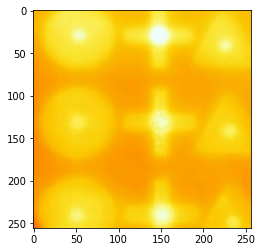

In [ ]:
## Normal images
path = glob.glob("./OK/*.jpg")
count = 0 
images_OK = []
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = img[30:-50]
    img = cv2.resize(img, (256,256))
    image = img  / 255. * 2. - 1.
    images_OK.append(image)
    count += 1
plt.imshow(img)
images_OK = np.asarray(images_OK)

y_test_ok = tf.constant([[1.]] * count)

## defekt images
path = glob.glob("./DEF/*.jpg")
y_test_def = tf.constant([[0.]] * len(path))
images_DEF = []
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = img[30:-50]
    img = cv2.resize(img, (256, 256))
    image = img  / 255. * 2. - 1.
    images_DEF.append(image)
plt.imshow(img)
images_DEF = np.asarray(images_DEF)

In [ ]:
print("\ -> 20")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_20.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 40")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_40.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 60")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_60.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 64")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_64.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 66")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_66.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 100")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_100.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 120")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_120.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 207")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_207.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 240")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_240.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 300")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_300.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 317")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_317.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)
print("\ -> 325")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_325.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)

\ -> 20
67/67 [==============================] - 1s 19ms/step - loss: 7.1466 - mae: 0.9059 - accuracy: 0.0899
\ -> 40
67/67 [==============================] - 1s 19ms/step - loss: 8.3027 - mae: 0.8312 - accuracy: 0.1443
\ -> 60
67/67 [==============================] - 1s 19ms/step - loss: 2.4207 - mae: 0.6451 - accuracy: 0.3321
\ -> 64
67/67 [==============================] - 1s 19ms/step - loss: 2.5275 - mae: 0.7149 - accuracy: 0.2777
\ -> 66
67/67 [==============================] - 1s 19ms/step - loss: 3.8951 - mae: 0.8992 - accuracy: 0.0885
\ -> 100
67/67 [==============================] - 1s 19ms/step - loss: 1.1410 - mae: 0.5051 - accuracy: 0.5132
\ -> 120
67/67 [==============================] - 1s 19ms/step - loss: 1.8164 - mae: 0.7361 - accuracy: 0.1906
\ -> 207
67/67 [==============================] - 1s 18ms/step - loss: 2.1494 - mae: 0.6752 - accuracy: 0.3202
\ -> 240
67/67 [==============================] - 1s 19ms/step - loss: 2.6700 - mae: 0.7798 - accuracy: 0.1443
\ -> 3

[3.077324151992798, 0.7532780170440674, 0.22658467292785645]

In [ ]:

print("\ -> 386")
discriminator = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4/gan_6_4_441.hdf5").layers[1]
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.evaluate(images_OK, y_test_ok)
discriminator.evaluate(images_DEF, y_test_def)

\ -> 386
67/67 [==============================] - 1s 18ms/step - loss: 2.7018 - mae: 0.7041 - accuracy: 0.2952


[2.7017927169799805, 0.7040536999702454, 0.2951750159263611]

In [ ]:
y_pred_ok = discriminator.predict(images_OK)
y_pred_def = discriminator.predict(images_DEF)
print(len(y_pred_ok[y_pred_ok < 0.95]), "/", len(y_pred_ok))
print(len(y_pred_def[y_pred_def > 0.95]), "/", len(y_pred_def))

355 / 2270
658 / 2114


100%|██████████| 1/1 [00:00<00:00, 222.05it/s]


array([[0.96998906]], dtype=float32)

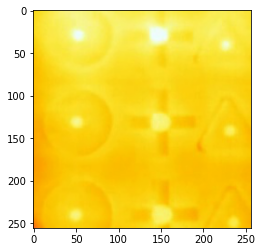

In [ ]:

## defekt images
path = glob.glob("./DEF/MyRecord2022-03-23T122437136.avi84801.jpg")
y_test_def = tf.constant([[0.]] * len(path))
images_DEF = []
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = img[30:-50]
    img = cv2.resize(img, (256, 256))
    image = img  / 255. * 2. - 1.
    images_DEF.append(image)
plt.imshow(img)
images_DEF = np.asarray(images_DEF)
y_pred_def = discriminator.predict(images_DEF)
y_pred_def

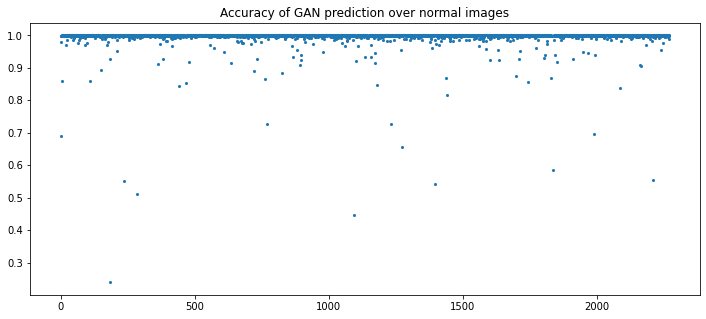

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(y_pred_ok))
y = y_pred_ok
ax.set_title("Accuracy of GAN prediction over normal images")
ax.scatter(x, y, marker='.',  linewidths=0.1)
# ax.axhline(y = 2600, color = 'r', linestyle = '-')
plt.show()

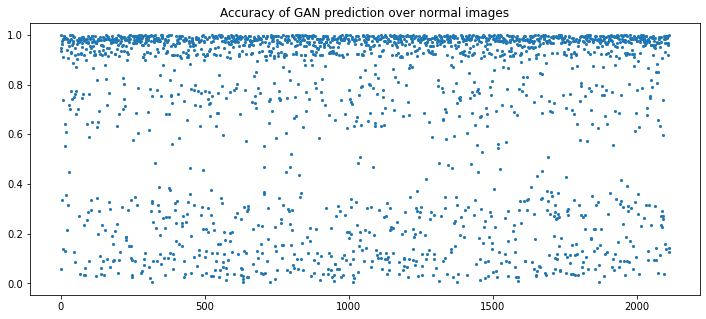

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(y_pred_def))
y = y_pred_def
ax.set_title("Accuracy of GAN prediction over normal images")
ax.scatter(x, y, marker='.',  linewidths=0.1)
# ax.axhline(y = 2600, color = 'r', linestyle = '-')
plt.show()

57
949
